references : https://www.youtube.com/watch?v=J0YcBKmLfbA&list=PLLENHvsRRLjDHllrXj0B8sz5-4xVbisBL&index=9

# Autoencoder

## 1. Settings

### 1) Import required libraries

In [2]:
# !pip install torch
# !pip install torchvision

In [2]:
import numpy as np
import torch
import torch.nn as nn
# 신경망 모델의 base class
# (layer 종류: nn.Linear,nn.Bilinear,nn.Fold,nn.RNN)
# (activation function 종류 : nn.Sigmoid, nn.ReLU, nn.LeakyReLU, nn.Softmin)
import torch.optim as optim
# 최적화 알고리즘 구현 패키지 (ex: optim.SGD, optim.Adam .. )
import torch.nn.init as init
import torchvision.datasets as dset
# torchvision : pytorch와 함께 사용되는 computer vision용 라이브러리 (이미지, 비디오 변환을 위한 유틸리티 및 일부 데이터 셋 제공)
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib as mpl

### 2) Set hyperparameters

In [3]:
batch_size = 256
learning_rate = 0.0002
num_epochs = 10

- batch_size : 몇개의 관측치에 대한 예측을 하고, 레이블 값과 비교를 하는지를 설정하는 파라미터
    - 배치사이즈가 100이면 전체 데이터에 대해 모두 예측한 뒤 실제 레이블 값과 비교한 후 가중치를 갱신
- epochs : 하나의 데이터셋을 몇 번 반복 학습할 지 정하는 파라미터
    - 너무 많은 epochs는 overfitting을 야기한다.

조금 더 쉽게 말하면, 1000개의 데이터가 있는데 batch_size = 10으로 설정 한다해보자.
그러면 총 10개의 batch가 그룹을 이뤄서 예측이 진행되고, 100번의 step을 통해 1epoch를 도는 것이다. 즉, 1epoch(학습1번) = 10(batch_size) * 100(step or iteration)
(batch_size가 커지면 한번에 많은양을 학습하므로 train 과정은 빨라지지만, 컴퓨터의 메모리 문제때문에 한계가 있다.)

## 2. Data

### 1) Download Data

In [4]:
mnist_train = dset.MNIST("./", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test = dset.MNIST("./", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_train, mnist_val = torch.utils.data.random_split(mnist_train, [50000, 10000]) # [50000, 10000] => [train_size, test_size]]

In [5]:
mnist_train[0][0].size()    # (1, 28, 28)

torch.Size([1, 28, 28])

In [6]:
mnist_train[0][1]          # label : mnist_train[0]이 의미하는 숫자

4

### 2) Set DataLoader

In [7]:
dataloaders = {}
dataloaders['train'] = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
dataloaders['val'] = DataLoader(mnist_val, batch_size=batch_size, shuffle=False)
dataloaders['test'] = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

In [12]:
print(len(dataloaders["train"])) # 196
print(len(dataloaders["val"])) # 40
print(len(dataloaders["test"])) # 40
answer=0
for n,data in enumerate(dataloaders['train']):
    if n == 1:
        break
    print(n+1,'번째 step을 보고 계십니다.')
    print('data는 이렇게 생겼습니다.')
    print(data)
    print('data를 더 자세히 보면')
    print(data[0][0][0]) # 4차원 데이터임을 알 수 있다.
    print('len(data[0]) : ',len(data[0])) # data[0]은 vector값
    print('len(data[1]) : ',len(data[1])) # data[1]은 label값
    answer+=1

196
40
40
1 번째 step을 보고 계십니다.
data는 이렇게 생겼습니다.
[tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]

Custom dataset / dataloader는 왜 필요한가
- 많은 양의 datga를 한번에 불러와 모델을 학습시키면 메모리가 부족 할 수 있기 때문에 custom dataset을 따로 만드는 것이다.
- 또한 input은 길이가 변하기 때문에 batch를 만들기 위해서는 Dataloader를 통해 mini batch를 만들어줘야한다.

## 3. Model & Optimizer

### 1) Model

In [13]:
# in my case: 784(28*28) -> 100 -> 30 -> 100 -> 784(28*28)

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder,self).__init__() # 이렇게 해줘야 부모모듈(nn.Module)의 __init__()을 사용 할 수 있다.
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 100),    
            nn.ReLU(),                          # activation function
            nn.Linear(100, 30),
            nn.ReLU()                           # activation function
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(30, 100),
            nn.ReLU(),                          # activation function
            nn.Linear(100, 28*28),
            nn.Sigmoid()                           # activation function
            # AutoEncoder 는 input과 output이 동일해야한다
            # input으로 0~1을 사용했으므로 output으로도 0~1을 출력해야 제대로 reconstruction을 해 주는것이다.
            # mnist_train[0][0]를 보면 Sigmoid minist value가 discrete value가 아니고
            # continuous value이므로 마지막 layer의 activation function은 sigmoid를 써야
            # output이 0~1 사잇값으로 input과 동일하게 출력한다.
        )

    # forwaed : 순전파 (<-> backward : 역전파)
    def forward(self, x):            # x: (batch_size, 1, 28, 28) 
        batch_size = x.size(0)
        x = x.view(-1, 28*28)                      # reshape to 784(28*28)-dimensional vector
        # 28*28 이미지 60000개를 batch_size인 256으로 나누다보면 자투리(나머지)가 남는데 그 것을 자동으로 채워준다.
        encoded = self.encoder(x)                # hidden vector
        out = self.decoder(encoded).view(batch_size,1,28,28)                   # final output. resize to input's size
        return out, encoded


### 2) Loss func & Optimizer

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# GPU 사용이 가능하다면 "cuda:0"이, 아니면 "cpu"를 device에 저장
print(device)

cpu


In [15]:
# 데이터 뒤에서 .to()를 사용
model = Autoencoder().to(device)
# 모델에서 사용하는 input Tensor들은 input = input.to(device) 을 호출해야 한다.
loss_func = nn.MSELoss()
# loss function으로는 MSE(Mean Squared Error) 사용
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# optimizer로는 Adam 사용
# '어떤 Optimizer를 써야되는지 잘 모르겠다면 Adam을 써라'라는 말도 있다 => optimizer은 나중에 따로 정리

## 4. Train 

In [16]:
import time
import copy

def train_model(model, dataloaders, criterion, optimizer, num_epochs=10):
    """
    model: model to train
    dataloaders: train, val, test data's loader
    criterion: loss function
    optimizer: optimizer to update your model
    """
    since = time.time() # 시간 측정

    # visualize를 위한 history를 저장할 lists
    train_loss_history = [] 
    val_loss_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict()) # 가장 좋은 파라미터 저장을 위한 deepcopy
    best_val_loss = 100000000 # 굉장히 큰 수를 val_loss를 저장하고 이것보다 작으면 update(처음엔 무조건 저장)

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()           
            else:
                model.eval()          

            running_loss = 0.0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)                                       # transfer inputs to GPU 

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):

                    outputs, encoded = model(inputs)
                    loss = criterion(outputs, inputs)                          # calculate a loss


                    # backward + optimize 는 train phase일 때만
                    if phase == 'train':
                        loss.backward()                             # perform back-propagation from the loss (train일때만)
                        optimizer.step()                             # perform gradient descent with given optimizer

                # statistics
                running_loss += loss.item() * inputs.size(0)                    

            epoch_loss = running_loss / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f}'.format(phase, epoch_loss))
            
            # deep copy the model
            if phase == 'train':
                train_loss_history.append(epoch_loss)
            
            if phase == 'val':
                val_loss_history.append(epoch_loss)

            if phase == 'val' and epoch_loss < best_val_loss:
                best_val_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                
            
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:4f}'.format(best_val_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_loss_history, val_loss_history

In [17]:
best_model, train_loss_history, val_loss_history = train_model(model, dataloaders, loss_func, optimizer, num_epochs=num_epochs)
# train Loss는 모델이 정말 크면 0으로 만들 수 있다
# => validation Loss는 그렇지 않다 ,, 따라서 validation Loss가 더이상 떨어지지 않을때! 까지 학습시켜야한다.
# => validation data set이 필요한 이유

Epoch 0/9
----------
train Loss: 0.1196
val Loss: 0.0700

Epoch 1/9
----------
train Loss: 0.0654
val Loss: 0.0589

Epoch 2/9
----------
train Loss: 0.0542
val Loss: 0.0483

Epoch 3/9
----------
train Loss: 0.0443
val Loss: 0.0412

Epoch 4/9
----------
train Loss: 0.0393
val Loss: 0.0374

Epoch 5/9
----------
train Loss: 0.0360
val Loss: 0.0344

Epoch 6/9
----------
train Loss: 0.0330
val Loss: 0.0316

Epoch 7/9
----------
train Loss: 0.0304
val Loss: 0.0293

Epoch 8/9
----------
train Loss: 0.0285
val Loss: 0.0277

Epoch 9/9
----------
train Loss: 0.0270
val Loss: 0.0262

Training complete in 0m 43s
Best val Loss: 0.026246


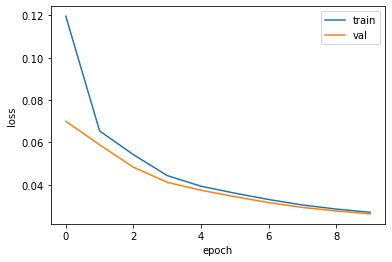

In [18]:
# Let's draw a learning curve like below.
plt.plot(train_loss_history, label = 'train')
plt.plot(val_loss_history, label = 'val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

## 5. Check with Test Image

In [19]:
# train case와 비슷하나 backpropagation이나 gradient descent step이 없다.
with torch.no_grad():
    running_loss = 0.0
    for inputs, labels in dataloaders["test"]:
        inputs = inputs.to(device)

        outputs, encoded = best_model(inputs)
        test_loss = loss_func(outputs, inputs)
        
        running_loss += test_loss.item() * inputs.size(0)

    test_loss = running_loss / len(dataloaders["test"].dataset)
    print(test_loss)

0.025818932443857193


- torch.no_grad() : gradient 연산을 하지 않는다 -> 메모리 사용을 아껴준다 + 계산속도 증가
- model.eval() : Dropout이나 Batchnorm 등 학습할때 사용하는 개념들은 비활성화 -> 해당 모델의 모든 레이어가 eval mode에 들어가게 해준다.

torch.Size([16, 28, 28])


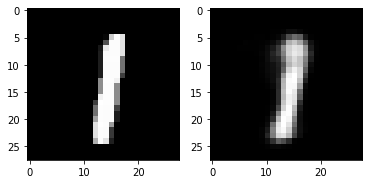

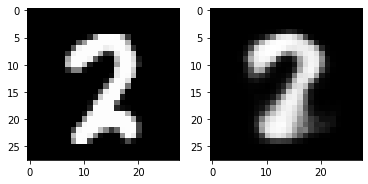

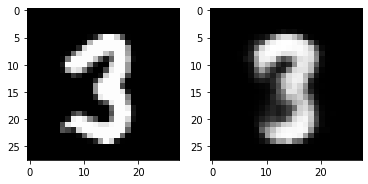

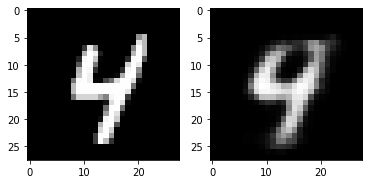

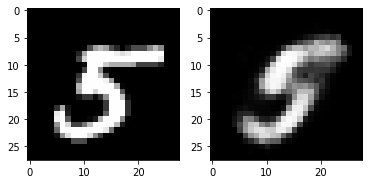

In [20]:
out_img = torch.squeeze(outputs.cpu().data)
print(out_img.size())

for i in range(5):
    plt.subplot(1,2,1)
    plt.imshow(torch.squeeze(inputs[i]).cpu().numpy(),cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(out_img[i].numpy(),cmap='gray')
    plt.show()

## 6. Visualizing MNIST

In [21]:
np.random.seed(42)

from sklearn.manifold import TSNE

In [22]:
test_dataset_array = mnist_test.data.numpy() / 255
test_dataset_array = np.float32(test_dataset_array)
labels = mnist_test.targets.numpy()

In [23]:
test_dataset_array = torch.tensor(test_dataset_array)
inputs = test_dataset_array.to(device)
outputs, encoded = best_model(inputs) # 여기서 뽑은 encoded는 30dimension

In [24]:
encoded = encoded.cpu().detach().numpy()
tsne = TSNE()   
X_test_2D = tsne.fit_transform(encoded) # 30 dimension짜리 enocded를 2 dimension으로 바꾸어야함
X_test_2D = (X_test_2D - X_test_2D.min()) / (X_test_2D.max() - X_test_2D.min())
# AutoEncoder로 30차원으로 줄여준 후 t-SNE로 다시 2차원으로 줄여서 시각화 하는 이유는?
# (처음부터 t-SNE로 2차원으로 줄이던가, AutoEncoder로 2차원으로 바로 줄이면 안되나?)
# 처음부터 t-SNE로 2차원으로 줄이면 => 굉장히 오래 걸릴 것이다.
# AutoEncoder로 2차원으로 바로 줄이면 => 분류가 되긴 하지만 덜 잘 될 것이다.
# => AutoEncoder의 reconstruction error minimize, t-SNE는 친밀도(Similarity)가 가까운 값끼리 묶는데 목적이 있다.

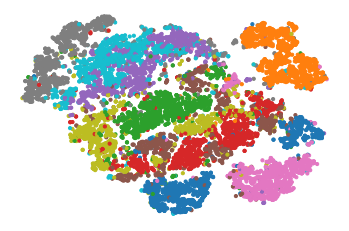

In [25]:
plt.scatter(X_test_2D[:, 0], X_test_2D[:, 1], c=labels, s=10, cmap="tab10")
plt.axis("off")
plt.show()

Let's make this diagram a bit prettier:

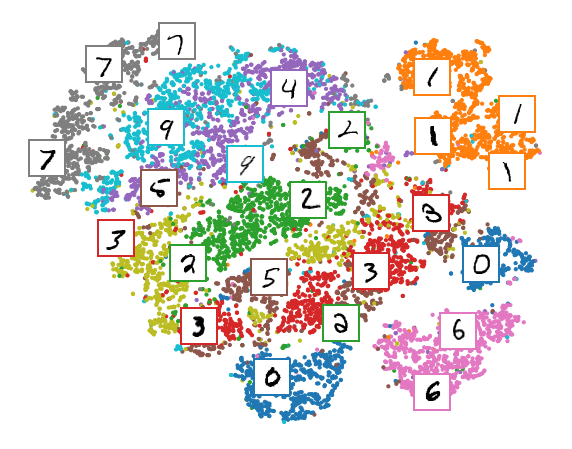

In [26]:
# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_test_2D[:, 0], X_test_2D[:, 1], c=labels, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_test_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(torch.squeeze(inputs).cpu().numpy()[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(labels[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()


# Denoising Autoencoder

In [27]:
model_D = Autoencoder().to(device)
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model_D.parameters(), lr=learning_rate)

In [28]:
def train_model_D(model, dataloaders, criterion, optimizer, num_epochs=10):
    """
    model: model to train
    dataloaders: train, val, test data's loader
    criterion: loss function
    optimizer: optimizer to update your model
    """
    since = time.time() # 시간 측정

    train_loss_history = []
    val_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict()) # 가장 좋은 파라미터 저장을 위한 deepcopy
    best_val_loss = 100000000 # 굉장히 큰 수를 val_loss를 저장하고 이것보다 작으면 update(처음엔 무조건 저장)

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()            # Set model to training mode
            else:
                model.eval()            # Set model to evaluate mode

            running_loss = 0.0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                noise = torch.zeros(inputs.size(0), 1, 28, 28) # DAE에서 추가된 부분
                nn.init.normal_(noise, 0, 0.1) # DAE에서 추가된 부분
                # noise는 1이 하얀색이므로 0에 가까운(굉장히 작은) 값을 noise로 넣어줘야
                # 1이 7이되거나 6이 8이되는 등의 변형을 막을 수 있다.
                noise = noise.to(device)
                inputs = inputs.to(device)                                       # transfer inputs to GPU 
                noise_inputs = noise + inputs
                # inputs과 noise_inputs을 구분해주는 이유는 loss를 구할때 noise를 넣지 않은 inputs이 필요하기 때문
                
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):

                    outputs, encoded = model(inputs)
                    loss = criterion(outputs, inputs)                          # calculate a loss


                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()                             # perform back-propagation from the loss (train일때만)
                        optimizer.step()                             # perform gradient descent with given optimizer

                # statistics
                running_loss += loss.item() * inputs.size(0)                    

            epoch_loss = running_loss / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f}'.format(phase, epoch_loss))
            
            # deep copy the model
            if phase == 'train':
                train_loss_history.append(epoch_loss)
            
            if phase == 'val':
                val_loss_history.append(epoch_loss)

            if phase == 'val' and epoch_loss < best_val_loss:
                best_val_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                
            
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:4f}'.format(best_val_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_loss_history, val_loss_history

In [29]:
best_model_D, train_loss_history_D, val_loss_history_D = train_model_D(model_D, dataloaders, loss_func, optimizer, num_epochs=20)

Epoch 0/19
----------
train Loss: 0.1167
val Loss: 0.0702

Epoch 1/19
----------
train Loss: 0.0662
val Loss: 0.0597

Epoch 2/19
----------
train Loss: 0.0545
val Loss: 0.0477

Epoch 3/19
----------
train Loss: 0.0432
val Loss: 0.0401

Epoch 4/19
----------
train Loss: 0.0382
val Loss: 0.0360

Epoch 5/19
----------
train Loss: 0.0342
val Loss: 0.0324

Epoch 6/19
----------
train Loss: 0.0312
val Loss: 0.0299

Epoch 7/19
----------
train Loss: 0.0289
val Loss: 0.0277

Epoch 8/19
----------
train Loss: 0.0268
val Loss: 0.0257

Epoch 9/19
----------
train Loss: 0.0249
val Loss: 0.0240

Epoch 10/19
----------
train Loss: 0.0234
val Loss: 0.0227

Epoch 11/19
----------
train Loss: 0.0221
val Loss: 0.0215

Epoch 12/19
----------
train Loss: 0.0211
val Loss: 0.0206

Epoch 13/19
----------
train Loss: 0.0203
val Loss: 0.0199

Epoch 14/19
----------
train Loss: 0.0196
val Loss: 0.0192

Epoch 15/19
----------
train Loss: 0.0189
val Loss: 0.0186

Epoch 16/19
----------
train Loss: 0.0184
val Loss

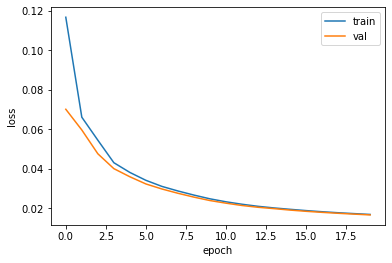

In [30]:
plt.plot(train_loss_history_D, label = 'train')
plt.plot(val_loss_history_D, label = 'val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [31]:
with torch.no_grad():
  running_loss = 0.0
  for inputs, labels in dataloaders['test']:
      noise = nn.init.normal_(torch.FloatTensor(inputs.size(0), 1, 28, 28), 0, 0.1)
      noise = noise.to(device)
      inputs = inputs.to(device)
      noise_inputs = inputs + noise

      outputs, encoded = best_model_D(noise_inputs)
      test_loss = loss_func(outputs, inputs)
      
      running_loss += test_loss.item()* inputs.size(0)

  test_loss = running_loss / len(dataloaders['test'].dataset)
  print(test_loss) 

0.01693590996414423


torch.Size([16, 28, 28])


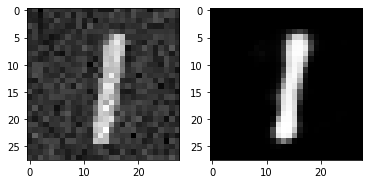

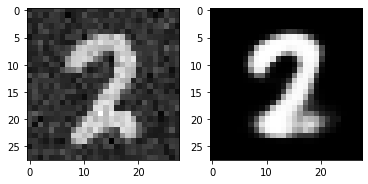

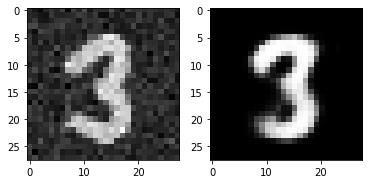

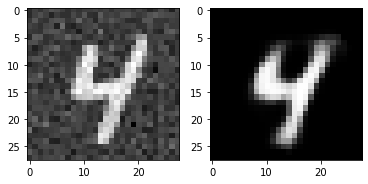

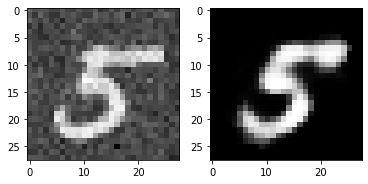

In [32]:
out_img = torch.squeeze(outputs.cpu().data)
print(out_img.size())

for i in range(5):
    plt.subplot(1,2,1)
    plt.imshow(torch.squeeze(noise_inputs[i]).cpu().numpy(),cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(out_img[i].numpy(),cmap='gray')
    plt.show()